## U-Net based ink removal experiments

The training data used here was created in the notebook `2019-10-29 Watermarks artificial manuscript overlay dataset generation`

This notebook is a cleanup from an earlier version at `2020-09-30_Deep_Ink_removal`, which itself derives from a 2019 notebook of the same name.

In [4]:
from fastai.vision.all import *
import torch
from torchvision.models import vgg16_bn
import torch.nn as nn
import torch.nn.functional as F
import gc

In [30]:
# Use best available GPU if present
try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device == torch.device('cuda', 0):
        torch.cuda.set_device(device)
except:
    device = torch.device('cpu')

print(f'Device is {device}')
path = Path('../data/ink_removal/ink_added/')


Device is cuda:0


In [19]:
def no_ink(fn):
    return path.parent/'original'/fn.name

def get_data(size, bs):
    '''This produces a datablock with images of the given size.
    
    The intention is to use this for progressive training of the U-Net.
    '''
    return DataBlock(
        blocks=(ImageBlock, ImageBlock),
        get_items=get_image_files,
        get_y=no_ink, # y refers to the target; given input filename, produce output filename
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(size),
        batch_tfms=aug_transforms(do_flip=True, flip_vert=True, min_scale=0.75, max_zoom=1.5)
    ).dataloaders(path, bs=bs, num_workers=0)

images = get_image_files(path)

## Feature loss

base_loss = F.l1_loss

vgg_m = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1).features.to(device).eval()
for x in vgg_m.parameters():
    x.requires_grad_(False) # only for feature generation, no training

blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]

def make_metric_func(fn, name):
    '''fastai wants each metric to have its own name'''
    fn.__name__ = name
    return fn

def gram_matrix(x):
    '''Measures cross-correlation among features.'''
    n, c, h, w = x.size()
    # print(f'{n, c, h, w = }')
    x = x.view(n, c, -1)
    # print(f'{x.shape = }')
    result = (x @ x.transpose(1, 2)) / (c*h*w)
    # print(f'{result.shape = }')
    return result

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        # For naming the metrics: first the pixel loss, then one per feature and one per gram loss.
        self.metric_names = ['pixel'] + [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]
        self.feat_losses = None

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        feat_losses = [base_loss(input, target)]
        feat_losses += [base_loss(f_in, f_out) * w for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w**2 * 5e3
                        for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses = feat_losses
        return sum(feat_losses), feat_losses

    def __del__(self):
        if hasattr(self, 'hooks'):
            self.hooks.remove()
    
    def metrics(self):
        names = ['pixel'] + [f'feat_{i}' for i in range(len(self.wgts))] + [f'gram_{i}' for i in range(len(self.wgts))]
        return [make_metric_func(
                    lambda preds, targs, idx=i: 0.0 if self.feat_losses is None 
                                                  else self.feat_losses[idx].detach().cpu().item(),
                    name)
                for i, name in enumerate(names)]

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])



In [24]:
## Train

wd = 1e-3 # weight decay
dls = get_data(40, 256) # image size, batch size
arch = resnet34 

learn = unet_learner(dls, arch, wd=wd, loss_func=lambda outs,targs: feat_loss(outs, targs)[0],
                     blur=True, norm_type=NormType.Weight, n_out=3, metrics=feat_loss.metrics())

lr = 3e-3
gc.collect()


79586

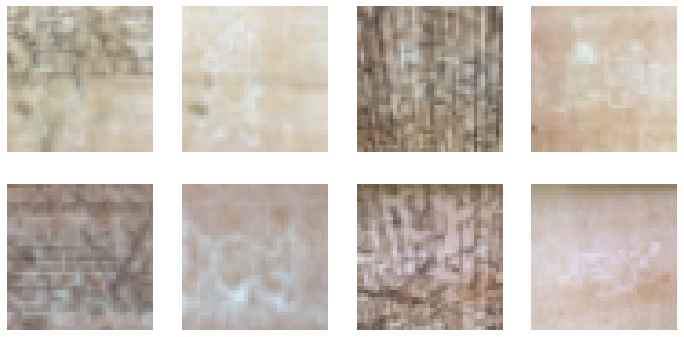

In [25]:
dls.train.show_batch(max_n=4, figsize=(12, 6))

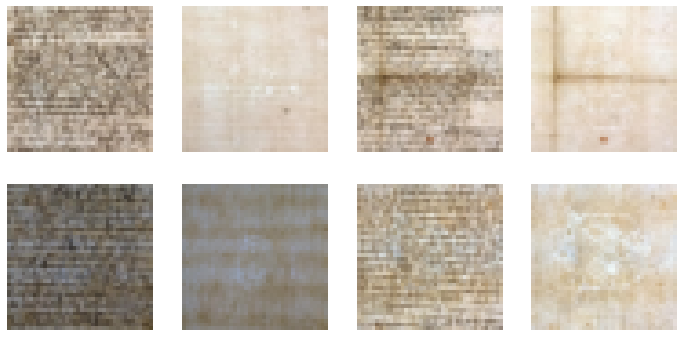

In [26]:
dls.valid.show_batch(max_n=4, figsize=(12, 6))

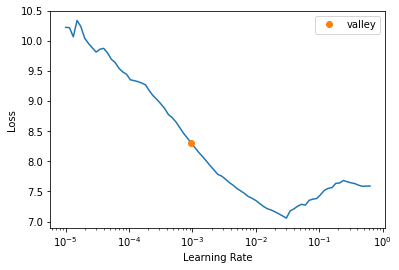

In [27]:
lr = learn.lr_find(start_lr=1e-5, end_lr=1e1)

In [28]:
lr.valley

0.0009549926035106182

In [29]:
def do_fit(save_name, lrs=slice(lr), epochs=10, pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start, cbs=[ShowGraphCallback()])
    learn.save(save_name)
    learn.show_results()

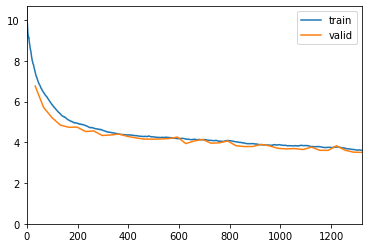

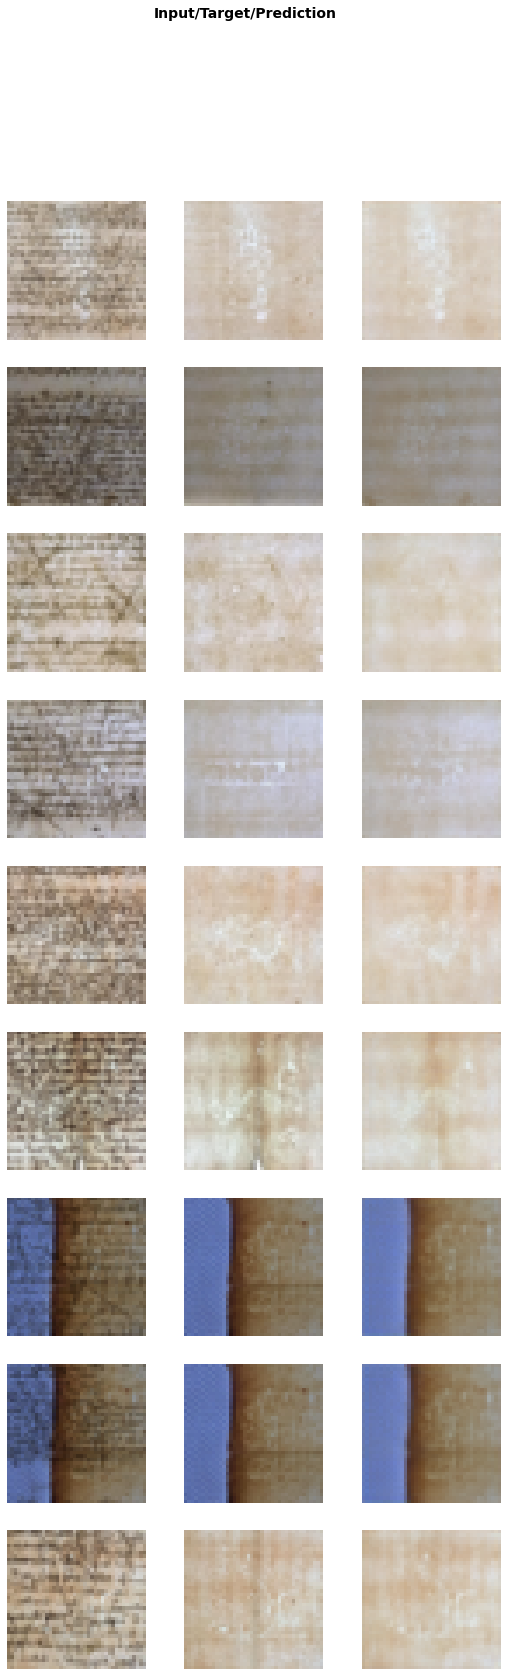

In [39]:
do_fit('magic_eraser_40px_a', 3e-3, epochs=40)

In [40]:
learn.recorder.metric_names

(#11) ['epoch','train_loss','valid_loss','pixel','feat_0','feat_1','feat_2','gram_0','gram_1','gram_2'...]

In [59]:
learn = learn.load('magic_eraser_40px_a')
dls = get_data(40, 256) # image size, batch size
learn.unfreeze()

In [60]:
lr

0.003

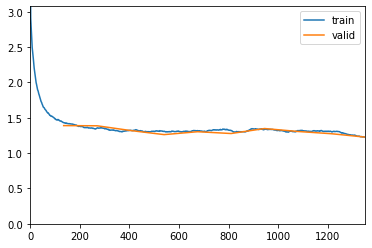

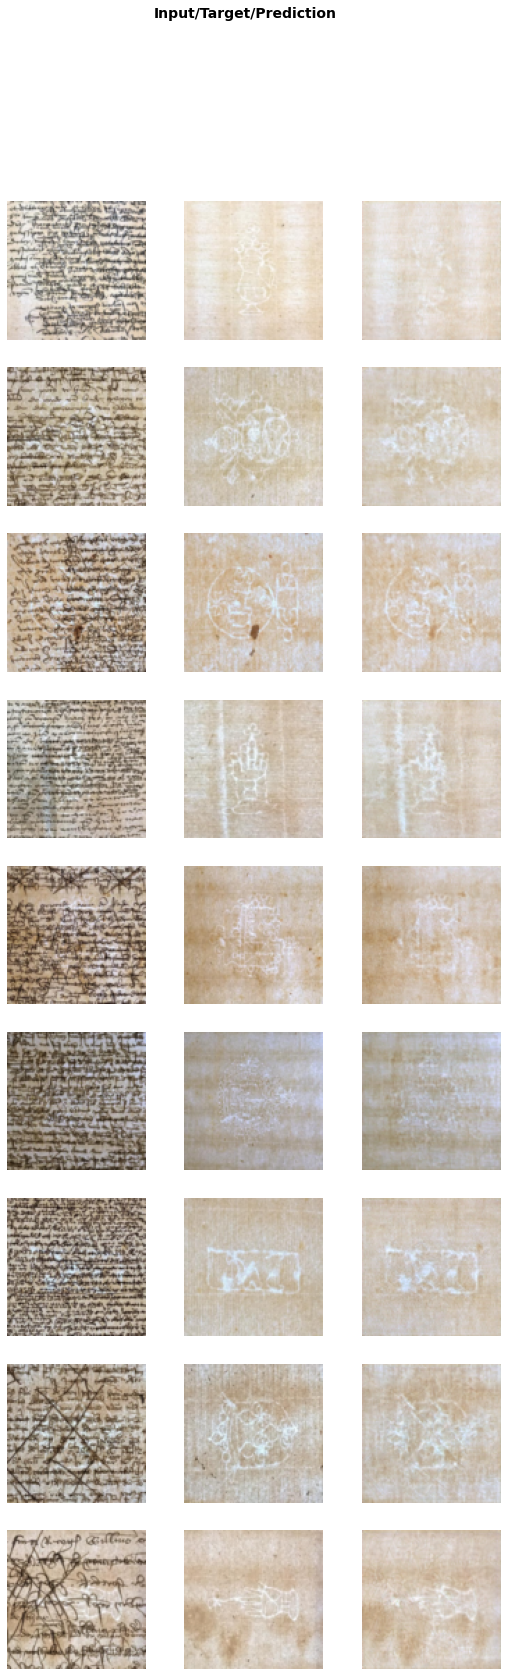

In [61]:
do_fit('magic_eraser_40px_b', slice(1e-5,3e-3))

In [65]:
learn = learn.load('magic_eraser_40px_b')
dls = get_data(100, 64)
learn.dls = dls
learn.freeze()
gc.collect()

23992

In [63]:
lr = 3e-3

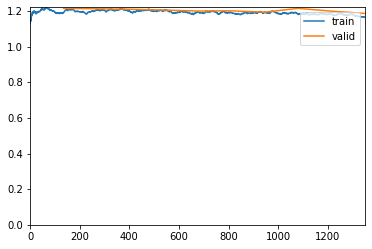

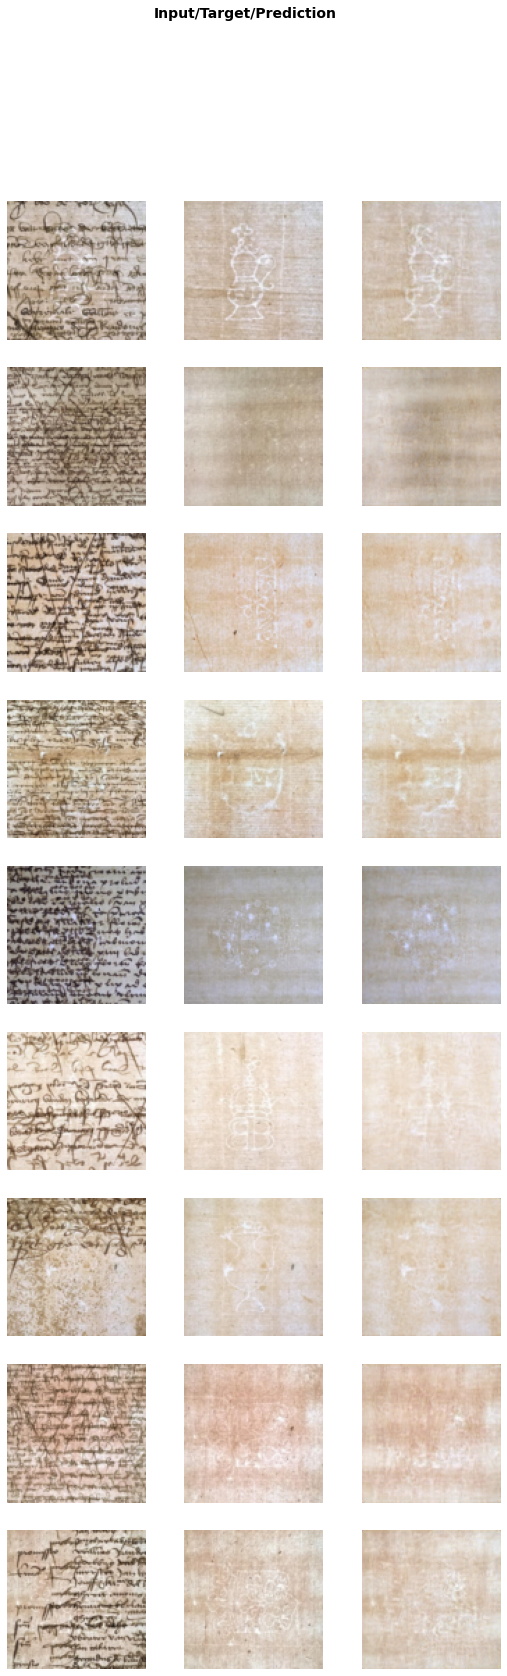

In [66]:
do_fit('magic_eraser_100px_a', lrs=(lr/10,))

In [67]:
learn.unfreeze()

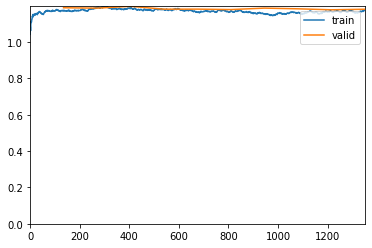

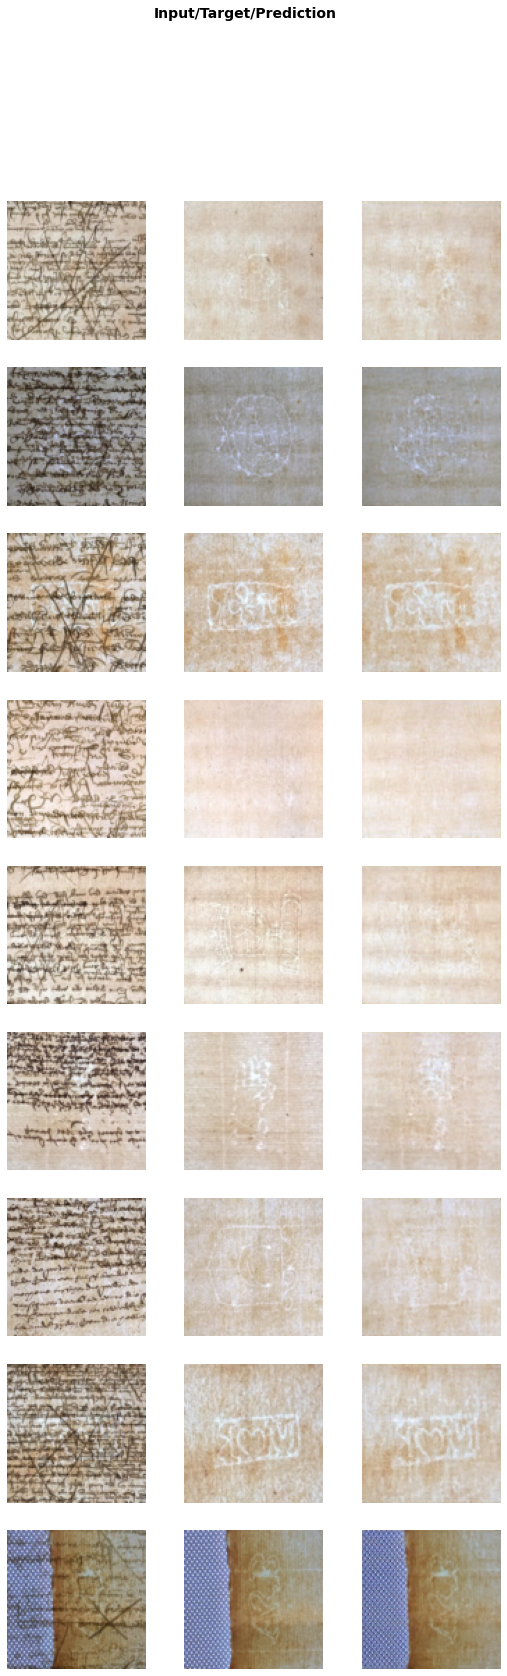

In [68]:
do_fit('magic_eraser_100px_b', slice(1e-6,1e-4), pct_start=0.3)

# Half resolution

In [69]:
dls = get_data(200, 32)

learn.dls = dls
learn.freeze()
gc.collect()

186778

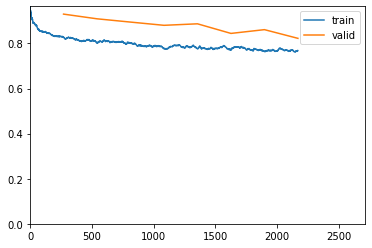

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
do_fit('magic_eraser_200px_a', slice(1e-3))#, pct_start=0.3)

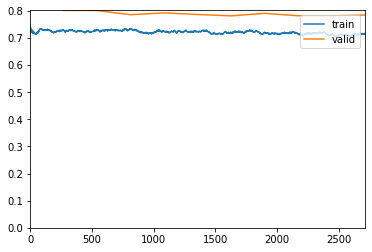

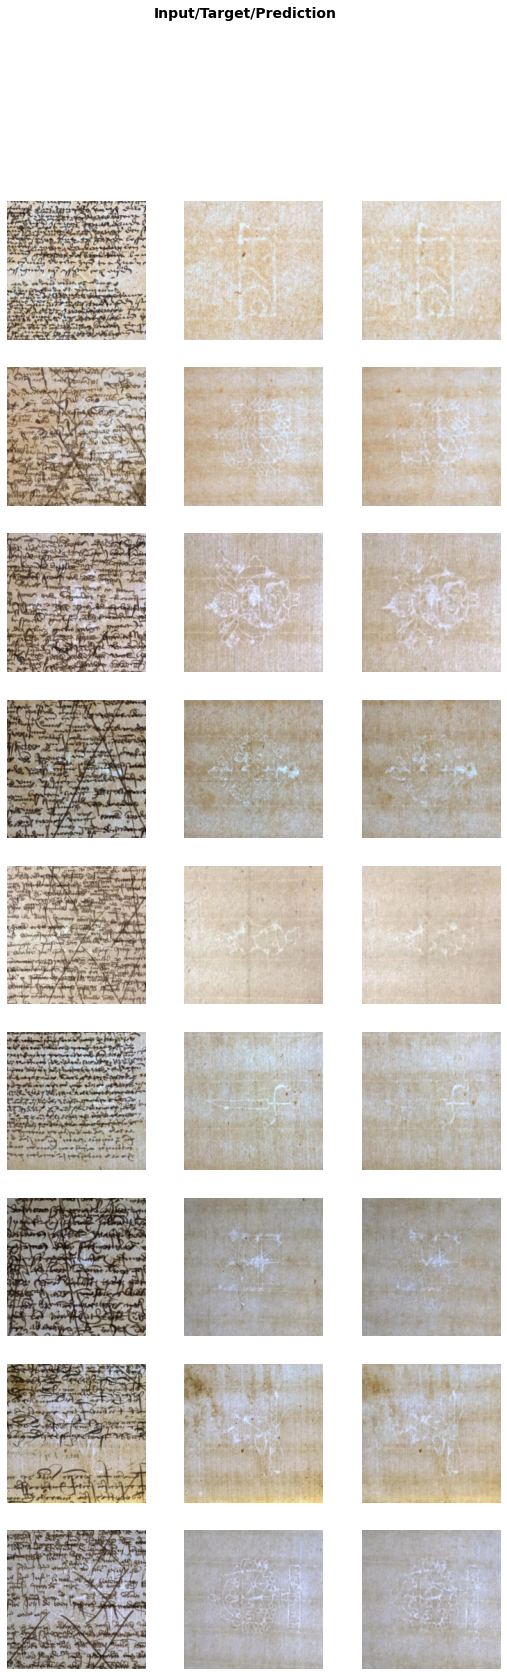

In [71]:
learn.unfreeze()
do_fit('magic_eraser_200px_b', slice(1e-6,1e-4), pct_start=0.3)

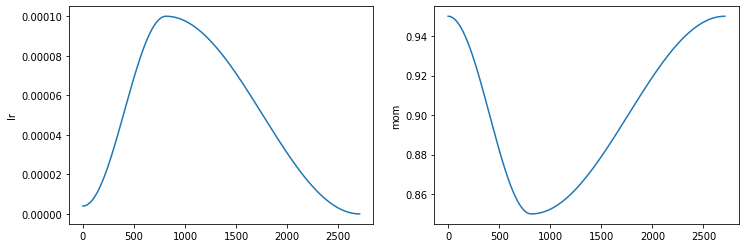

In [72]:
learn.recorder.plot_sched()

# Full resolution

In [79]:
learn = learn.load('magic_eraser_200px_b')

In [80]:
dls = get_data(400, 20)

learn.dls = dls
learn.freeze()
gc.collect()

37510

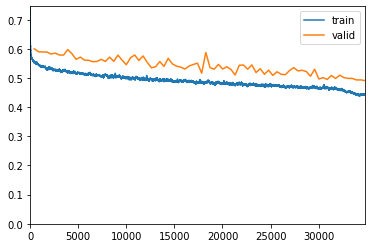

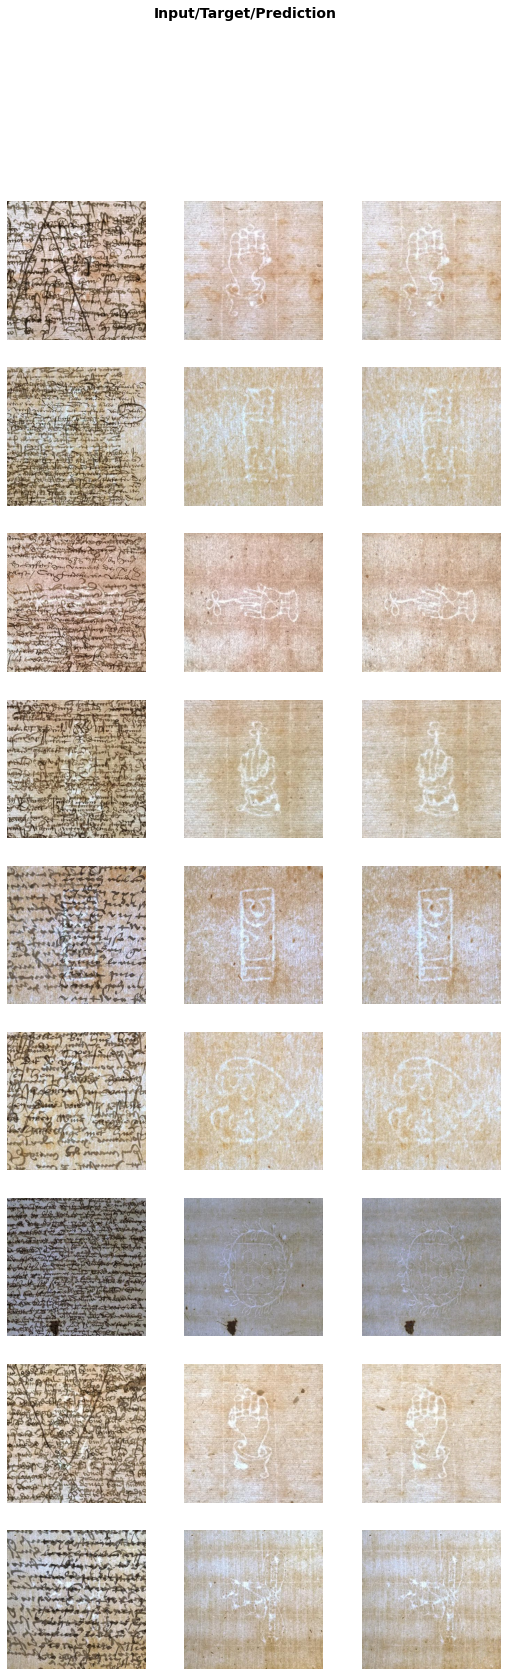

In [81]:
do_fit('magic_eraser_400px_a', epochs=80)

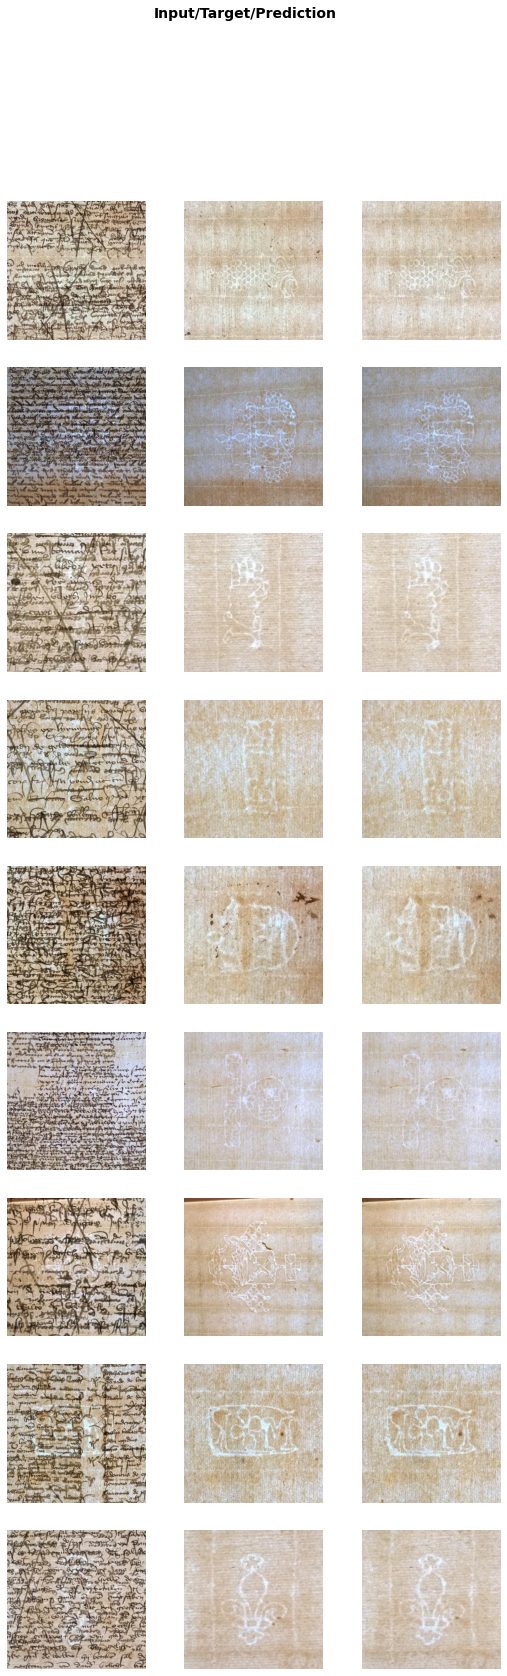

In [11]:
learn.show_results()

## Full-resolution unfrozen fine-tuning

In [ ]:
learn.unfreeze()
do_fit('resnet34_new_4d', slice(1e-6,1e-4), pct_start=0.3, epochs=80)

In [ ]:
learn.show_results()

In [ ]:
learn.recorder.plot_metrics()

In [49]:
torch.save(learn.model.cpu(), 'magic_eraser_400px_a_pytorch.pt')